# DCGAN_Face_Generate

(Code is modified from pytorch official DCGAN [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html))

Remember to check the runtime of your notebook is GPU. Expected training time is about 20 ~ 40 minutes using GPU (depends on Colab).

## Download the Anime Face Dataset from Kaggle and upload to your google drive

*   https://www.kaggle.com/datasets/splcher/animefacedataset?resource=download



In [1]:

'''
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/data/' # dataset's dir you want to unzip

if not os.path.exists(data_dir):
  zip_dir = '/content/gdrive/MyDrive/Colab_Notebooks/archive.zip' # your zip file's dir

  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(data_dir)
'''

"\nimport zipfile\nfrom google.colab import drive\n\ndrive.mount('/content/gdrive')\ndata_dir = '/content/gdrive/MyDrive/Colab_Notebooks/data/' # dataset's dir you want to unzip\n\nif not os.path.exists(data_dir):\n  zip_dir = '/content/gdrive/MyDrive/Colab_Notebooks/archive.zip' # your zip file's dir\n\n  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:\n      zip_ref.extractall(data_dir)\n"

In [2]:
'''
from pathlib import Path
from torchvision.datasets.utils import download_file_from_google_drive, extract_archive

# img_align_celeba.zip if celeb daataset
dataset_path = './archive.zip'
# dataset_path = './img_align_celeba.zip'

zip_path = Path(dataset_path)
data_dir = Path('./data/')

if not zip_path.exists():
    download_file_from_google_drive(
        ('1L4ITJcEcvxQ3TqOknkYYUDoglGoylwHu' if 'celeb' in dataset_path else '13Ux9h3pkCBPnC8J9BLi32DLlaVSFdHn7'), '.', str(zip_path))

if not Path('./data/img_align_celeba').exists():
    extract_archive(str(zip_path), str(data_dir))
elif not Path('./data/images').exists():
    extract_archive(str(zip_path), str(data_dir))
'''

"\nfrom pathlib import Path\nfrom torchvision.datasets.utils import download_file_from_google_drive, extract_archive\n\n# img_align_celeba.zip if celeb daataset\ndataset_path = './archive.zip'\n# dataset_path = './img_align_celeba.zip'\n\nzip_path = Path(dataset_path)\ndata_dir = Path('./data/')\n\nif not zip_path.exists():\n    download_file_from_google_drive(\n        ('1L4ITJcEcvxQ3TqOknkYYUDoglGoylwHu' if 'celeb' in dataset_path else '13Ux9h3pkCBPnC8J9BLi32DLlaVSFdHn7'), '.', str(zip_path))\n\nif not Path('./data/img_align_celeba').exists():\n    extract_archive(str(zip_path), str(data_dir))\nelif not Path('./data/images').exists():\n    extract_archive(str(zip_path), str(data_dir))\n"

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Sampler, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision import transforms as tsfm

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

import os

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

2024-05-29 00:13:56.299897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 00:13:57.050541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Custom Pytorch Dataset and Dataloader


A `Dataset` in Pytorch should have two methods:

1. `__len__`: return a integer indicating the size of the dataset
2. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
data/
    img_align_celeba/
        000001.jpg
        000002.jpg
        ...
```

We can simply find all the jpegs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the jpeg (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [4]:
class dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.img_paths = list(Path(root_dir).glob('*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        return img

data_dir = "../archive"

data = dataset(os.path.join(data_dir, 'images'), transform=tsfm.Compose([
    tsfm.Resize((64, 64)),
    tsfm.ToTensor(),
    tsfm.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
]))

print('#sample:', len(data))

#sample: 63565


/home/yuyu/anaconda3/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


torch.Size([128, 3, 64, 64])


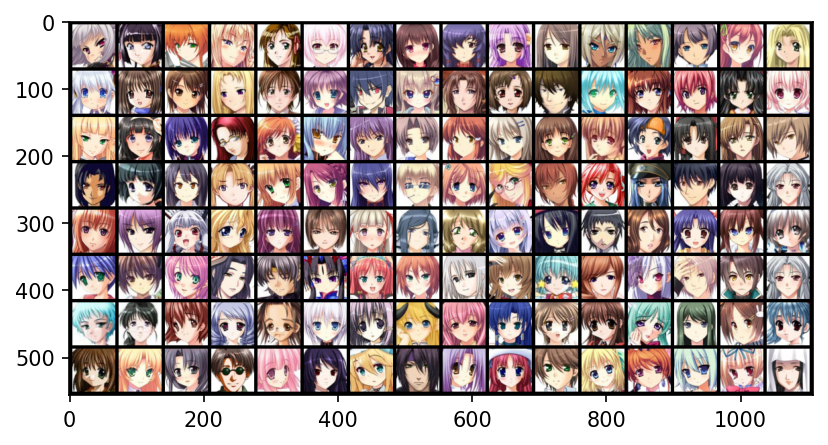

In [5]:
class InfiniteSampler(Sampler):
    def __init__(self, data_source):
        super().__init__(data_source)
        self.N = len(data_source)

    def __iter__(self):
        while True:
            for idx in torch.randperm(self.N):
                yield idx

loader = iter(
    DataLoader(
        data,
        batch_size=128,
        num_workers=4,
        sampler=InfiniteSampler(data)
    )
)

img_b = next(loader)    # retrieve a mini-batch
print(img_b.size())     # expected [128, 3, 64, 64]

# visualization
vis = tsfm.ToPILImage()(make_grid(img_b, nrow=16, padding=5, normalize=True))
fig, ax = plt.subplots(dpi=150)
ax.imshow(vis)
plt.show()

## Generator and Discriminator

To draw an vector following normal distribution $\mathcal{N}(\mu, \sigma^2)$ in pytorch, one can write:
```python
torch.normal(mean, std, shape) # shape is the desire dimension
```
So `torch.normal(0.0, 1.0, [100])` will get an vector of size 100 with each element following $\mathcal{N}(0, 1)$.

In this implementation, we need to reshape latent vector `z` of shape `[100]` to `[100, 1, 1]` so that we can simplify some code in generator. Therefore, to make generator `G` create a mini-batch of fake images from standard normal distribution is

```python
fake_b = G(torch.normal(0.0, 1.0, (128, 100, 1, 1)))
# fake_b has shape [128, 3, H, W]
```

Don't forget the leading dimension 128! It means there are 128 samples in this mini-batch.


# Homework: Change the architecture of Generator and Discriminator

*   Please change the structure of Generator and Discriminator below and add a block to explain the changes.

In [8]:
nz = 100    # Size of z latent vector (i.e. size of generator input)
ngf = 64    # Size of feature maps in generator
ndf = 64    # Size of feature maps in discriminator
nc = 3     # Number of channels in the images. For color images this is 3

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4

    # New block added here
    nn.ConvTranspose2d(ngf * 8, ngf * 8, 3, 1, 1, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4

    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 8 x 8
    nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 16 x 16
    nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # state size. (ngf) x 32 x 32
    nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (nc) x 64 x 64
)

D = nn.Sequential(
    # input is (nc) x 64 x 64
    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf) x 32 x 32

    # New block added here
    nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 32 x 32

    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 16 x 16
    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 8 x 8
    nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

print(G)
print(D)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## 原始架構

### 生成器 (Generator)
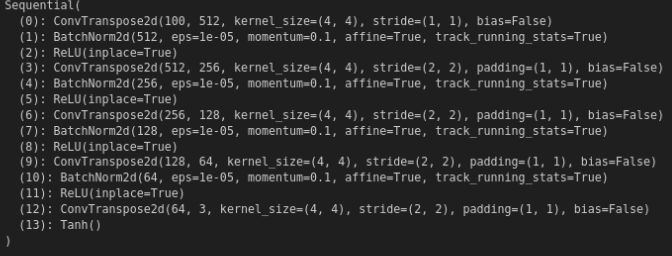

### 判別器 (Discriminator)
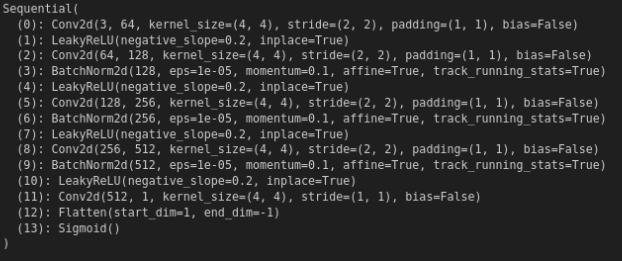

## 改動說明

在這個改版中，我們對生成器和判別器的架構進行了如下改動：

### 生成器 (Generator)
1. 在第一個區塊之後新增了一個上採樣區塊，以增加生成器的複雜度。這個區塊包括一個 ConvTranspose2d 層、一個 BatchNorm2d 層和一個 ReLU 激活函數。

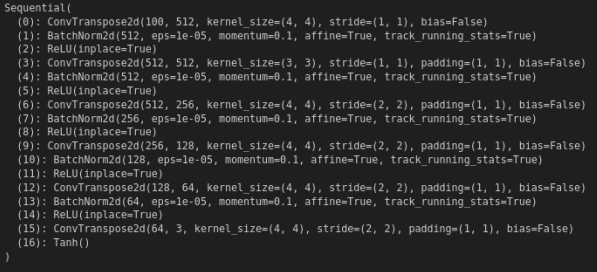

### 判別器 (Discriminator)
1. 在第一個區塊之後新增了一個下採樣區塊，以增加判別器的深度和容量。這個區塊包括一個 Conv2d 層、一個 BatchNorm2d 層和一個 LeakyReLU 激活函數。

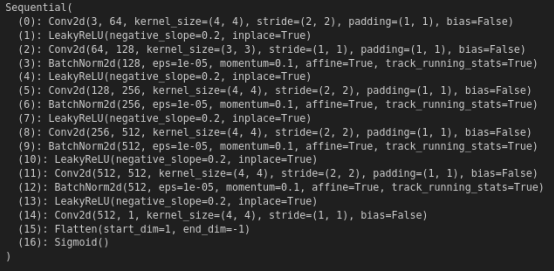

通過新增這些區塊，我們希望提高網絡生成和判別更複雜特徵的能力。

## Training


In [9]:
!rm -rf ./vis*

# Weight init, GAN is sensitive to initialized weight
G.apply(weight_init)
D.apply(weight_init)

# Move the model to GPU
device = 'cuda'
G = G.to(device)
D = D.to(device)

# Specify criterion (loss function) and optimizers
# Note that there are 2 optimizers, one for generator, one for discriminator.
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Fixed latent vector used for visualization
fixed_latent = torch.randn(128, nz, 1, 1).to(device)

history = {
    'step': [],
    'lossG': [],
    'lossD': [],
}

# Train 5k steps. tqdm is for progress bar.
for step in tqdm(range(5000 + 1)):

    # 1. Train Discriminator

    # 1a. Clear all previous gradient
    optimizerD.zero_grad()

    # 1b. Forward + Backward with real images
    try:
        real_b = next(loader).to(device)                            # [128, 3, 64, 64]
    except:
        loader = iter(                                        # reset loader
            DataLoader(
                data,
                batch_size=128,
                num_workers=4,
                sampler=InfiniteSampler(data)
            )
        )
        real_b = next(loader).to(device)

    label_b = torch.ones(128).to(device)                          # [128]
    output_b = D(real_b).flatten()                             # [128]
    lossD_real = criterion(output_b, label_b)                       # scalar
    lossD_real.backward()

    # 1c. Forward + Backward with fake images
    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device))  # [128, 3, 64, 64]
    label_b = torch.zeros(128).to(device)                 # [128]
    output_b = D(fake_b).flatten()                    # [128]
    lossD_fake = criterion(output_b, label_b)              # scalar
    lossD_fake.backward()

    # Now 1b's gradients and 1c's gradients are accumulated on each parameter.
    # 1d. Optimize
    optimizerD.step()


    # 2. Train Generator
    # Note that the label is ones
    # Since we want to fool discriminator as much as possible
    optimizerG.zero_grad()
    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device)) # [128, 3, 64, 64]
    input_b = fake_b                           # [128, 3, 64, 64]
    label_b = torch.ones(128).to(device)                 # [128]
    output_b = D(input_b).flatten()                   # [128]
    lossG = criterion(output_b, label_b)                # scalar
    lossG.backward()
    optimizerG.step()

    lossG = lossG.item()
    lossD = lossD_real.item() + lossD_fake.item()
    history['step'].append(step)
    history['lossG'].append(lossG)
    history['lossD'].append(lossD)

    # 3. Logging
    if step % 50 == 0:
        print('Step {:04d}: lossG={:6.3f}, lossD={:6.3f}'.format(step, lossG, lossD))


    # 4. Visualization
    if step % 100 == 0:
        G.eval()
        vis = G(fixed_latent).detach().cpu()
        vis = make_grid(vis, nrow=16, padding=5, normalize=True)
        vis = tsfm.ToPILImage()(vis)
        vis.save('vis{:04d}.jpg'.format(step))
        G.train()

  0%|          | 0/5001 [00:00<?, ?it/s]

Step 0000: lossG= 9.768, lossD= 0.979
Step 0050: lossG=40.343, lossD= 0.000
Step 0100: lossG=39.474, lossD= 0.000
Step 0150: lossG=39.117, lossD= 0.000
Step 0200: lossG=38.661, lossD= 0.000
Step 0250: lossG=38.057, lossD= 0.000
Step 0300: lossG=36.929, lossD= 0.000
Step 0350: lossG=15.739, lossD=11.790
Step 0400: lossG= 5.694, lossD= 0.339
Step 0450: lossG= 6.349, lossD= 0.093
Step 0500: lossG= 5.340, lossD= 0.452
Step 0550: lossG= 4.437, lossD= 0.696
Step 0600: lossG= 3.341, lossD= 0.699
Step 0650: lossG= 7.061, lossD= 0.268
Step 0700: lossG= 6.115, lossD= 0.627
Step 0750: lossG= 7.054, lossD= 3.557
Step 0800: lossG= 3.084, lossD= 0.362
Step 0850: lossG= 3.223, lossD= 0.364
Step 0900: lossG= 8.634, lossD= 0.932
Step 0950: lossG= 2.453, lossD= 2.363
Step 1000: lossG= 4.279, lossD= 0.206
Step 1050: lossG= 4.645, lossD= 0.222
Step 1100: lossG= 3.670, lossD= 0.493
Step 1150: lossG= 6.670, lossD= 2.096
Step 1200: lossG= 4.586, lossD= 0.476
Step 1250: lossG= 5.817, lossD= 1.243
Step 1300: l

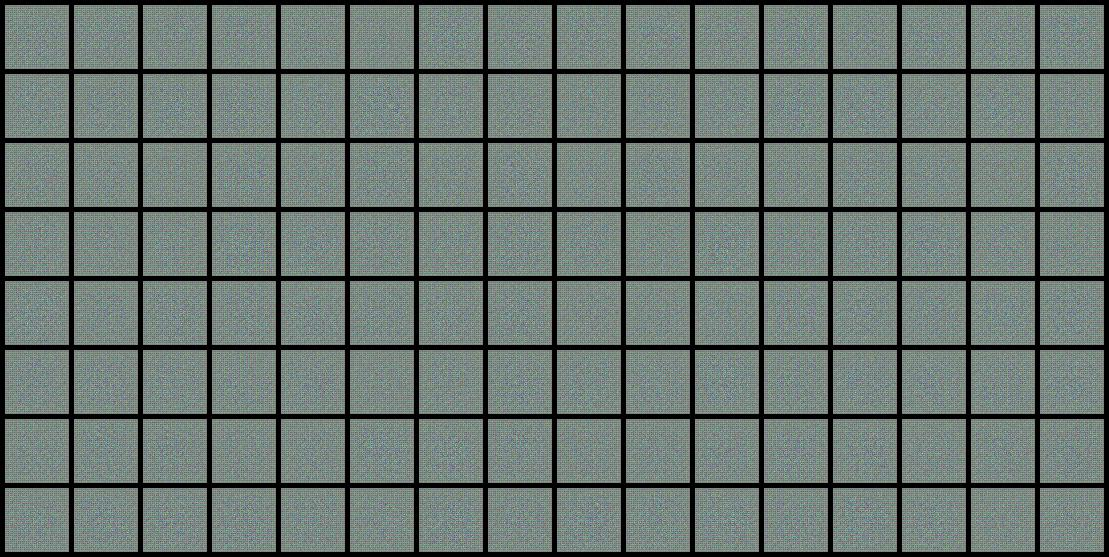

In [11]:
display.Image('vis0000.jpg')

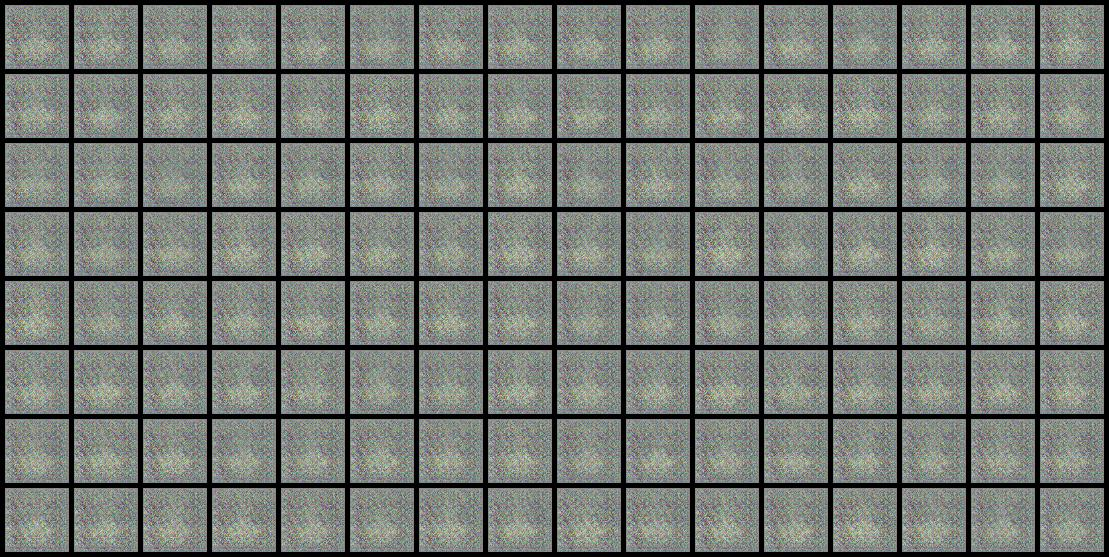

In [10]:
display.Image('vis0200.jpg')

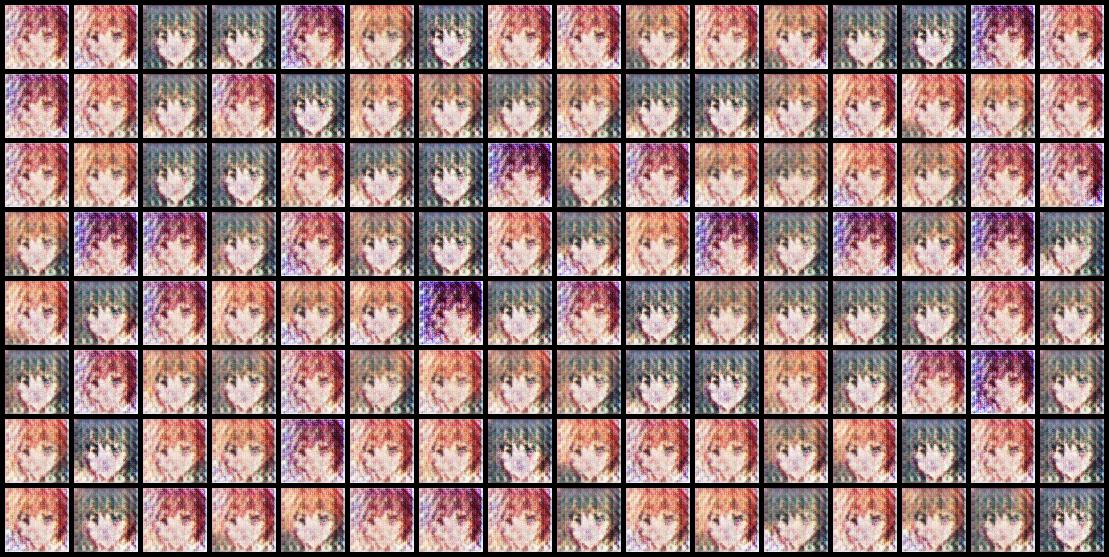

In [12]:
display.Image('vis1000.jpg')

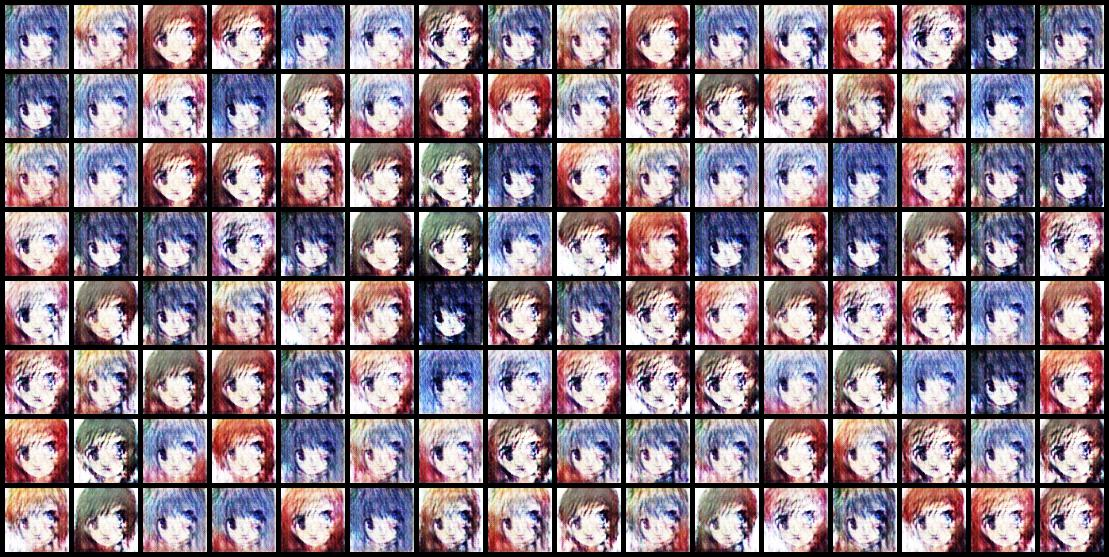

In [13]:
display.Image('vis2500.jpg')

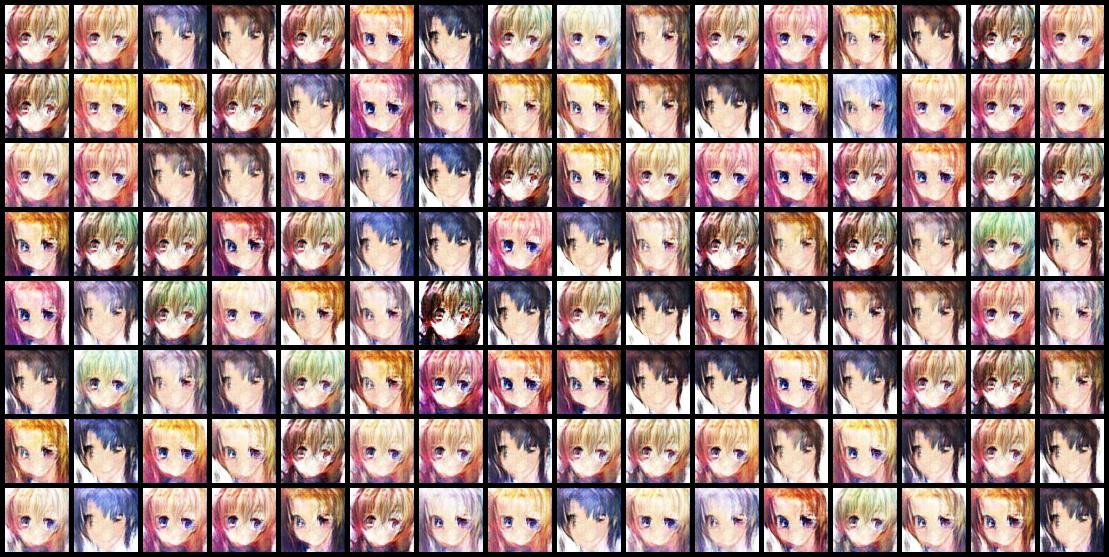

In [14]:
display.Image('vis5000.jpg')

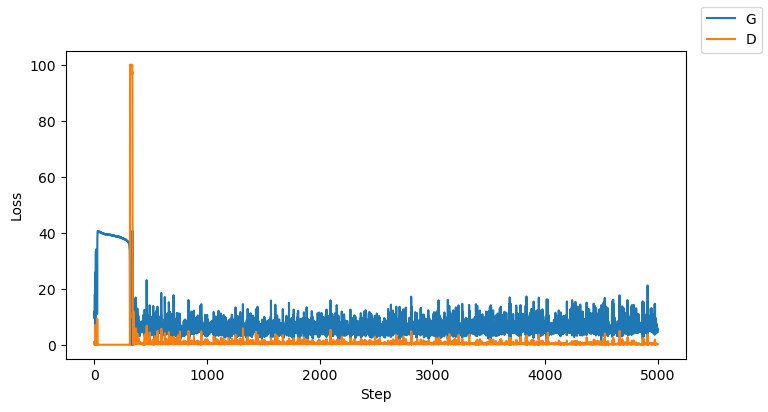

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history['step'], history['lossG'], label='G')
ax.plot(history['step'], history['lossD'], label='D')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
fig.legend()
plt.show()

## Evaluation

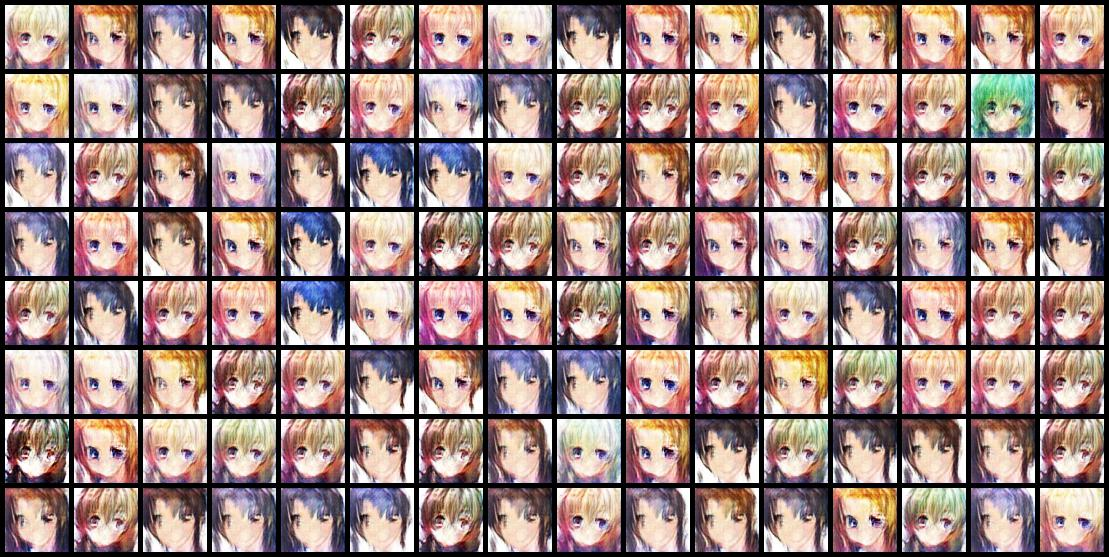

In [16]:
with torch.no_grad():
    G.eval()

    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')

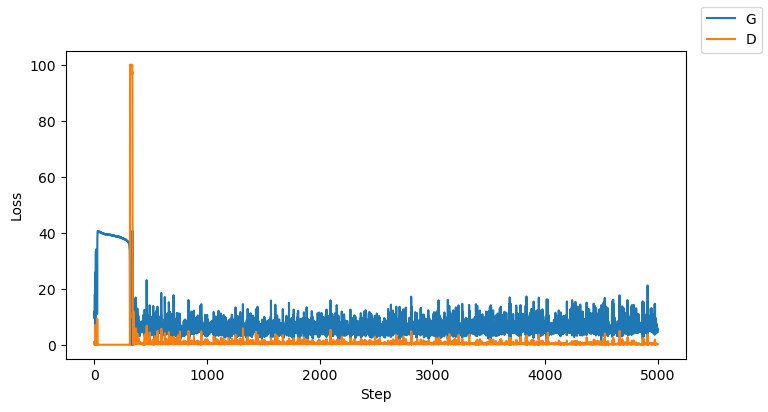

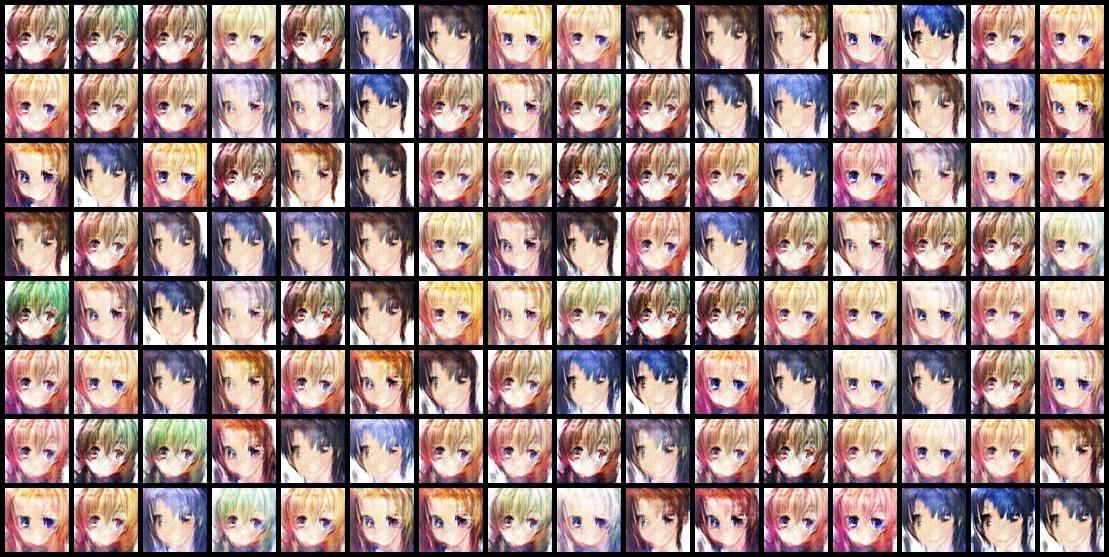

In [17]:
#from google.colab import drive
import numpy as np

#drive.mount('/content/gdrive/')

np.save('step.npy', history['step'])
np.save('lossG.npy', history['lossG'])
np.save('lossD.npy', history['lossD'])
torch.save(G.state_dict(), 'generator.pt')

load_step = np.load('step.npy').tolist()
load_lossG = np.load('lossG.npy').tolist()
load_lossD = np.load('lossD.npy').tolist()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(load_step, load_lossG, label='G')
ax.plot(load_step, load_lossD, label='D')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
fig.legend()
plt.show()

nz = 100    # Size of z latent vector (i.e. size of generator input)
ngf = 64    # Size of feature maps in generator
ndf = 64    # Size of feature maps in discriminator
nc = 3      # Number of channels in the images. For color images this is 3

load_G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4

    # New block added here
    nn.ConvTranspose2d(ngf * 8, ngf * 8, 3, 1, 1, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4

    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 8 x 8
    nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 16 x 16
    nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # state size. (ngf) x 32 x 32
    nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (nc) x 64 x 64
)

load_G.load_state_dict(torch.load('generator.pt'))

device = 'cuda'
load_G = load_G.to(device)
with torch.no_grad():
    load_G.eval()

    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')